In [1]:
import fiona
from shapely.geometry import shape

In [2]:
with fiona.open('./EZG/Basiseinzugsgebiet (AWGN)_polygon.shp', 'r') as f:
    features = [_ for _ in f]
    crs = f.crs
    schema = f.schema

print(f"Found {len(features)} features")
crs

Found 9352 features


{'init': 'epsg:25832'}

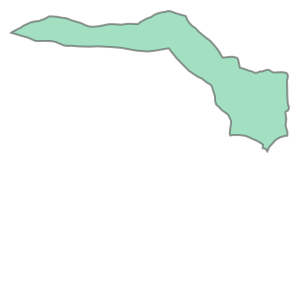

In [3]:
feat = features[0]
s = shape(feat['geometry'])
s

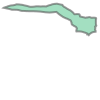

In [4]:
import pyproj
from shapely.ops import transform

if 'init' in crs:
    src = pyproj.CRS(crs['init'])
else:
    src = pyproj.CRS.from_dict(crs)
tgt = pyproj.CRS('EPSG:4326')
transformer = pyproj.Transformer.from_crs(src, tgt, always_xy=True).transform

poly = transform(transformer, s)
poly

In [5]:
from wetterdienst.provider.dwd.observation import DwdObservationRequest, DwdObservationDataset, DwdObservationPeriod, DwdObservationResolution

stations = DwdObservationRequest(
    parameter=DwdObservationDataset.CLIMATE_SUMMARY,
    resolution=DwdObservationResolution.DAILY,
    period=DwdObservationPeriod.RECENT,
)

df = stations.filter_by_bbox(*poly.bounds)

Dircache located at /home/mirko/.cache/wetterdienst


In [6]:
res = stations.filter_by_distance(latitude=poly.centroid.y, longitude=poly.centroid.x, distance=10)
res.df.head()

,station_id,from_date,to_date,height,latitude,longitude,name,state,distance
0,03621,1947-01-01 00:00:00+00:00,2022-04-04 00:00:00+00:00,435.0,48.8253,10.5067,Reimlingen,Bayern,8.016834


In [7]:
for r in res.values.query():
    df = r.df.dropna()

parameters {'true_local_time', 'end_of_interval'} are skipped in tidy format as the date parameters are currently not converted to floats


In [8]:
for par, grp in df.groupby('parameter'):
    print(grp.empty)

True
True
True
True
False
False
True
False
False
False
False
False
False
False


In [77]:
a = dict(foo='bar', baz=42)
b = dict(baz=42, foo='bar')

print(hash(str(frozenset(a.items()))))
print(hash(str(frozenset(b.items()))))

-8386729875556860757
-8386729875556860757


In [9]:
from wetterdienst.provider.dwd.radar import DwdRadarParameter, DwdRadarPeriod, DwdRadarResolution, DwdRadarValues
from datetime import datetime as dt, timedelta as td

radolan = DwdRadarValues(
    parameter=DwdRadarParameter.RADOLAN_CDC,
    resolution=DwdRadarResolution.HOURLY,
    period=DwdRadarPeriod.RECENT,
    start_date=dt.now() - td(days=10),
    end_date=dt.now()
)

In [10]:
import wradlib as wrl
import warnings

data = []
attributes = []
timestamps = []
warnings.filterwarnings('ignore')

for item in radolan.query():
    #ts, buffer = item
    timestamps.append(item.timestamp)
    d, attribute = wrl.io.read_radolan_composite(item.data)
    data.append(d)
    attributes.append(attribute)

100%|█████████▉| 239/240 [00:03<00:00, 61.39it/s]


In [14]:
# get radolan projection
proj_osr = wrl.georef.create_osr('dwd-radolan')

# get raw corner coords
xy_raw  =wrl.georef.get_radolan_grid(900, 900)
rado_rast, xy = wrl.georef.set_raster_origin(data[-1], xy_raw, 'upper')

# create gdal Dataset
rado_ds = wrl.georef.create_raster_dataset(rado_rast, xy, proj_osr)

rado_ds

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f4d67c13960> >

In [24]:
import tempfile
import rasterio


with tempfile.NamedTemporaryFile('w+b') as tmp:
    wrl.io.write_raster_dataset(tmp.name, rado_ds, 'GTiff')
    src = rasterio.open(tmp.name)


src

<open DatasetReader name='/tmp/tmp8pnjjikb' mode='r'>

In [42]:
src.crs

tgt_proj = pyproj.CRS(src.crs)
src_proj = pyproj.CRS.from_epsg(4326)

transformer = pyproj.Transformer.from_crs(src_proj, tgt_proj, always_xy=True).transform
poly_radolan2d = transform(transformer, poly2d)

In [38]:
# get rid of 3rd dimension
poly2d = transform(lambda x, y, z=None: (x, y), poly)

In [44]:
from rasterio.mask import mask
from shapely.geometry import mapping
mask_data, mask_transform = mask(src, shapes=[poly_radolan2d], crop=True)

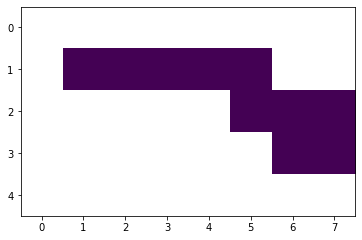

In [51]:
maskeddata = np.ma.masked_equal(mask_data[0], attributes[-1]['nodataflag'])
plt.imshow(maskeddata)

<Figure size 720x576 with 0 Axes>

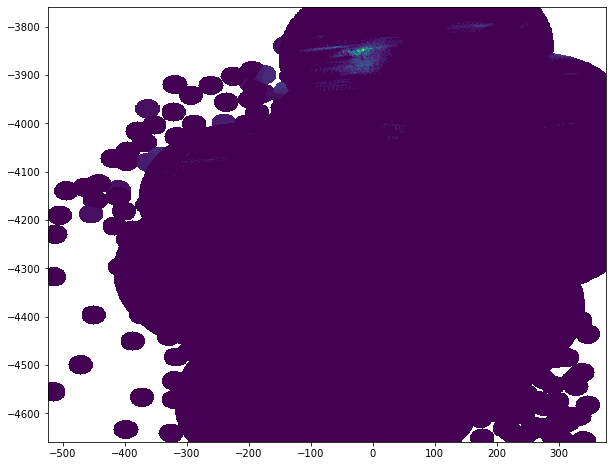

In [12]:
import numpy as np
maskeddata = np.ma.masked_equal(data[-1], attributes[-1]['nodataflag'])

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
# get coordinates
radolan_grid_xy = wrl.georef.get_radolan_grid(900, 900)
x = radolan_grid_xy[:, :, 0]
y = radolan_grid_xy[:, :, 1]

# create quick plot with colorbar and title
plt.figure(figsize=(10, 8))
plt.pcolormesh(x, y, maskeddata)

In [ ]:
out_img, out_transform = mask(rast, shapes=[mapping(poly)], crop=True, nodata=-9999)

AttributeError: '_GeneratorContextManager' object has no attribute 'transform'